<a href="https://colab.research.google.com/github/igoravelli/brazilian_soccer_championship_analysis/blob/main/Teams_accuracy_pass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pandasql

import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import sys

from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

data_table.enable_dataframe_formatter()
auth.authenticate_user()


project = 'brasileirao-362523'
schema = 'exp_brasileirao'
location = 'US'

client = bigquery.Client(project=project, location=location)

# Extract data

In [2]:
# @title Get factPontuacao
ft_pont = client.query(f"""
      SELECT * FROM `{project}.{schema}.exp_fatoPontuacao`
    """).to_dataframe()

ft_pont.set_index('pk_pontuacao', inplace=True)
ft_pont.head()

,ano_campeonato,posicao,fk_id_time,pontuacao,num_vitorias,num_vitorias_mandante,num_vitorias_visitante
pk_pontuacao,,,,,,,
4000118,2016,18,1004,28,7,7,0
4000158,2014,20,1210,32,7,7,0
4000258,2009,20,1455,31,7,7,0
4000278,2008,20,1359,35,9,9,0
4000020,2021,20,1166,15,1,0,1


In [3]:
# @title Get factEstatisiticas
ft_stats = client.query(f"""
      SELECT * FROM `{project}.{schema}.exp_semifatoEstatisticas`
    """).to_dataframe()

ft_stats.set_index('pk_estatisticas', inplace=True)
ft_stats.head()

,fk_id_partida,fk_id_time,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
pk_estatisticas,,,,,,,,,,,,
3000001,1,1340,0,0,0.0,0,0.0,0,0,0,0,0
3000002,1,1476,0,0,0.0,0,0.0,0,0,0,0,0
3000003,2,1013,0,0,0.0,0,0.0,0,0,0,0,0
3000004,2,1319,0,0,0.0,0,0.0,0,0,0,0,0
3000005,3,1245,0,0,0.0,0,0.0,0,0,0,0,0


In [4]:
# @title Get dimTime data
dim_time = client.query(f"""
      SELECT * FROM `{project}.{schema}.exp_dimTime`
    """).to_dataframe()

dim_time.set_index('pk_time', inplace=True)
dim_time.head()

,nome,estado,arena,tecnico,start_id,end_id
pk_time,,,,,,
1225,csa,AL,estadio_rei_pele,M._Ribeiro_Cabo,6513,6589
1226,csa,AL,estadio_rei_pele,A._Fucks,6601,6861
1227,csa,AL,estadio_rei_pele,G._Santos_Vasconcelo,6869,6879
1079,bahia,BA,itaipava_arena_fonte_nova,N/A,8,4612
1080,bahia,BA,itaipava_arena_fonte_nova,M._dos_Santos_Goncalves,4623,4730


In [5]:
# @title Get dimPartida data
dim_partida = client.query(f"""
      SELECT * FROM `{project}.{schema}.exp_dimPartida`
    """).to_dataframe()

dim_partida.set_index('pk_partida', inplace=True)
dim_partida.head()

,estadio,visitante,mandante,rodada,data_partida,ano_campeonato,formacao_mandante,formacao_visitante,vencedor,perdedor
pk_partida,,,,,,,,,,
1,100028,1476,1340,1,2003-03-29 16:00:00,2003,N/A,N/A,guarani,vasco
2,100012,1319,1013,1,2003-03-29 16:00:00,2003,N/A,N/A,athletico-pr,gremio
3,100104,1183,1245,1,2003-03-30 16:00:00,2003,N/A,N/A,None,None
4,100144,1392,1299,1,2003-03-30 16:00:00,2003,N/A,N/A,None,None
5,100023,1393,1341,1,2003-03-30 16:00:00,2003,N/A,N/A,None,None


In [6]:
# @title Join factPontuacao, factEstatisiticas, dimTime
df_position = ft_pont.merge(dim_time, left_on='fk_id_time', right_on='pk_time', how='inner')

df_position = df_position[["ano_campeonato","nome","posicao"]]

df_accuracy = ft_stats.merge(dim_time, left_on='fk_id_time', right_on='pk_time', how='inner').merge(dim_partida, left_on='fk_id_partida', right_on='pk_partida', how='inner')

df_accuracy = df_accuracy[["ano_campeonato","nome","precisao_passes"]]

# Transformations

In [7]:
# @title Pass accuracy analysis
df_accuracy = df_accuracy[df_accuracy["precisao_passes"] != 0.0] # Remove data in which the precision pass is zero

df_accuracy = df_accuracy.groupby(['ano_campeonato','nome']).agg({'precisao_passes':['mean']})

df_accuracy = df_accuracy[('precisao_passes','mean')].reset_index()

df_accuracy.columns = df_accuracy.columns.get_level_values(0)

df_accuracy = df_accuracy.merge(df_position, left_on=['ano_campeonato','nome'], right_on=['ano_campeonato','nome'], how='inner')

df_accuracy.columns = ['Year','Club name', 'Pass accuracy', 'League position']

print(df_accuracy)

    Year     Club name  Pass accuracy  League position
0   2018    america-mg       0.790526               18
1   2018  athletico-pr       0.841053                7
2   2018   atletico-mg       0.827368                6
3   2018         bahia       0.785526               11
4   2018   botafogo-rj       0.775263                9
..   ...           ...            ...              ...
75  2021     juventude       0.794211               16
76  2021     palmeiras       0.814474                3
77  2021        santos       0.816053               10
78  2021     sao_paulo       0.814737               13
79  2021         sport       0.802632               19

[80 rows x 4 columns]


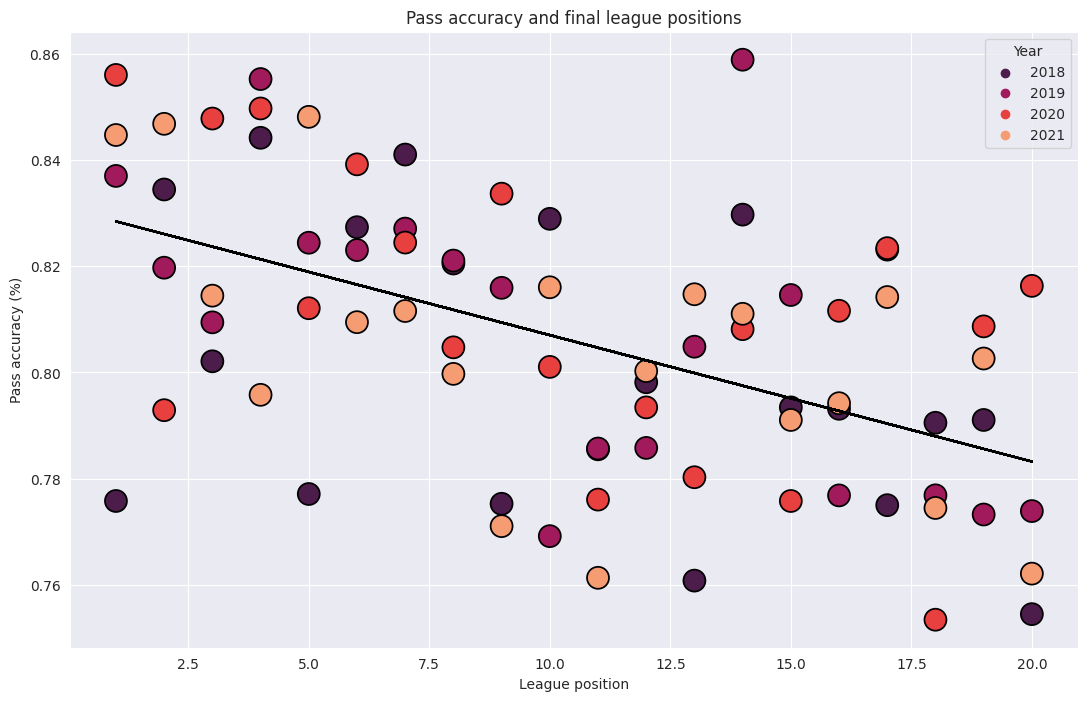

In [8]:
# @title Plot chart
plt.rcParams["figure.figsize"] = [13, 8]
sns.set_style("darkgrid")

sns.scatterplot(data=df_accuracy, x="League position", y="Pass accuracy", hue="Year", s=250, palette="rocket", edgecolor="black")

X = df_accuracy["League position"].values.reshape(-1, 1)
Y = df_accuracy["Pass accuracy"].values.reshape(-1, 1)
lin_regressor = LinearRegression()
lin_regressor.fit(X, Y)
Y_pred = lin_regressor.predict(X)

plt.plot(X, Y_pred, color='black')

plt.title("Pass accuracy and final league positions")
plt.xlabel("League position")
plt.ylabel("Pass accuracy (%)")

plt.show()

# Conclusion

This notebook shows a study about the relation between the pass accuracy of the teams and their final league position. For the analysis, it was considered the data from the 2018 edition onwards, due to the data quality about the pass accuracy, once that some values in previous years were missing.

In conclusion, it can be observed in the last chart that there is a correlation between the pass accuracy and a team's likelihood of securing a favorable position in the league table. A high level of precision in passing not only facilitates effective ball circulation but also enables teams to maintain possession (avoiding opponent´s pressure), create scoring opportunities, and control the rhythm of the match.

